In [1]:
import socket
import pickle
# import cloudpickle as pickle
import numpy as np
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata
from tvm.contrib import graph_executor
import json
import time
import sys
import cv2
import struct
from argparse import ArgumentParser
import ntplib 
from multiprocessing import Process, Queue
import os

In [2]:
import matplotlib.pyplot as plt


In [3]:
args_model = 'unet'
args_target = 'cuda'
args_img_size = 512
args_opt_level = 3
# target and dev set
if args_target == 'llvm':
    target = 'llvm'
    dev = tvm.cpu()
elif args_target == 'cuda':
    target = 'cuda'
    dev = tvm.cuda()
elif args_target == 'opencl':
    target = 'opencl'
    dev = tvm.opencl()

In [4]:
NETWORK_WEIGHT = 0.00000000854636931
NETWORK_BAIS = 0.000004568534259
MODEL_TEST_TIME = 253
NETWORK_TEST_TIME = 1000
def network_cost(data_shape, data_type):
    data_size = 1
    for d in data_shape:
        data_size = data_size * d
    if data_type == 'float32':
        return 4 * data_size * NETWORK_WEIGHT + NETWORK_BAIS 
    elif data_type == 'int8':
        return data_size * NETWORK_WEIGHT + NETWORK_BAIS 
    else:
        return None

In [4]:
def make_preprocess(model, im_sz):
    if model == 'unet':
        def preprocess(img):
            return cv2.resize(img[490:1800, 900:2850], (im_sz,im_sz)).astype(np.float32) / 255
        return preprocess
    elif model == 'resnet152':
        def preprocess(img):
            return cv2.resize(img, (im_sz, im_sz))
        return preprocess

preprocess = make_preprocess(args_model, args_img_size)

In [5]:
def load_data():
    cap = cv2.VideoCapture("../../../tvm-slicer/src/data/j_scan.mp4")
    data_queue = []
    while (cap.isOpened()):
        ret, frame = cap.read()
        try:
            frame = preprocess(frame)    
        except:
            data_queue.append([])
            # frame_queue.put({-1:-1})
            # result_queue.put({-1:-1})
            break
        data_queue.append(frame)
    cap.release()
    return data_queue


In [6]:
def get_model_info(partition_points):
    model_input_indexs = []
    model_output_indexs = []
    model_graph_json_strs = []

    # If there is no model to be executed
    if len(partition_points) == 1:
        return [partition_points], [partition_points], []

    # Load front model json infos
    for i in range(len(partition_points) - 1):
        start_point = partition_points[i]
        end_point = partition_points[i + 1]
        current_file_path = "./"
        with open(current_file_path + "../src/graph/{}_{}_{}_{}_{}-{}.json".format(args_model, args_target, args_img_size, args_opt_level, start_point, end_point), "r") as json_file:
            graph_json = json.load(json_file)
        input_indexs = graph_json['extra']["inputs"]
        output_indexs = graph_json['extra']["outputs"]
        
        model_input_indexs.append(input_indexs)
        model_output_indexs.append(output_indexs)
        del graph_json['extra']
        model_graph_json_strs.append(json.dumps(graph_json))

    return model_input_indexs, model_output_indexs, model_graph_json_strs


In [11]:
data_queue = load_data()
frame = data_queue[40]

In [9]:
info = """0,5|0.34996962547302246
0,11|0.5121638774871826
0,13|0.588925838470459
0,19|0.6701910495758057
0,25|0.7726650238037109
0,27|0.8159186840057373
0,33|0.8914945125579834
0,39|0.9934201240539551
0,41|1.0133213996887207
0,47|1.0853333473205566
0,53|1.1703181266784668
0,55|1.1873586177825928
0,61|1.280874252319336
0,72|2.060703992843628
0,73|2.0565340518951416
0,79|2.257066488265991
0,90|2.9114270210266113
0,91|2.8966686725616455
0,97|3.0954058170318604
0,108|3.9590346813201904
0,109|3.9419052600860596
0,115|4.096070051193237
0,126|5.504796743392944
0,127|5.496886968612671
0,133|5.700417757034302
0,141|5.855103492736816"""
dsts = []
for i in info.split("\n"):
    dsts.append(int(i.split('|')[0].split(',')[1]))

In [12]:
model_path = "../src/model/{}_{}_full_{}_{}.so".format(args_model, args_target, args_img_size, args_opt_level)
lib = tvm.runtime.load_module(model_path)
param_path = "../src/model/{}_{}_full_{}_{}.params".format(args_model, args_target, args_img_size, args_opt_level)
with open(param_path, "rb") as fi:
    loaded_params = bytearray(fi.read())

In [29]:
outs = []
for dst in dsts:
    points_front_model = [0,dst]
    front_input_idxs, front_output_idxs, front_graph_json_strs = get_model_info(points_front_model)
    front_models = []
    for graph_json_str in front_graph_json_strs:
        model = graph_executor.create(graph_json_str, lib, dev)
        model.load_params(loaded_params)
        front_models.append(model)
    input_data = np.expand_dims(frame, 0).transpose([0, 3, 1, 2])
    front_models[0].set_input("input_{}".format(0), input_data)
    front_models[0].run()
    dev.sync()
    outs.append(front_models[0].get_output(0).numpy())

In [32]:
outs[1]

array([[[[ -1,   0,  -9, ...,  -6,  -2,  -2],
         [  5,   8,  -5, ...,   0,  -2,  -4],
         [  4,   3, -11, ...,  -4,  -3,  -6],
         ...,
         [  1,   9,   6, ...,   7,   7,   7],
         [  0,   8,   6, ...,   7,   7,   9],
         [  2,   2,   1, ...,   1,   0,   1]],

        [[  5,   7,   5, ...,   0,   3,  -3],
         [ 11,  13,  13, ...,   4,   9,  -4],
         [  9,  13,  10, ...,   3,  10,  -4],
         ...,
         [  2,  -8,  -6, ...,  -9,  -8, -14],
         [  2,  -9,  -7, ...,  -9,  -8, -14],
         [ -3,  -9,  -8, ...,  -9,  -9, -12]],

        [[  8,  29,   9, ...,   3,  -9,   4],
         [ 16,  41,  11, ...,   2,  -8,  -2],
         [ 19,  48,  11, ...,   4,  -4,  -8],
         ...,
         [  1,   0, -10, ..., -13, -11,   1],
         [  1,   0,  -4, ...,  -6,  -8,   4],
         [ -1,  -7,  -9, ...,  -7,  -7,  14]],

        ...,

        [[ -5,   3,   5, ...,   4,   8,   6],
         [ -8,   0,   5, ...,   5,   7,   8],
         [ -6,   3

In [20]:
for i in outs:
    print(i.shape)

(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 16, 512, 512)
(1, 32, 512, 512)
(1, 16, 512, 512)
(1, 1, 512, 512)


In [25]:
def image_show(imgs):
    sqrt = int(np.sqrt(len(imgs)))
    try:
        for i, img in enumerate(imgs):
            plt.subplot(sqrt, sqrt, i + 1)
            plt.imshow(img, 'gray')
    except:
        continue
    plt.show()

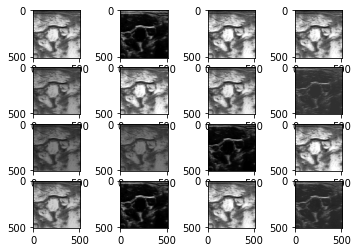

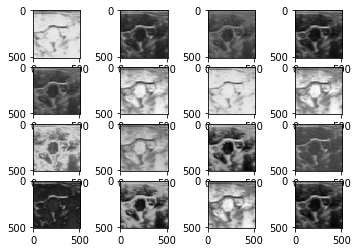

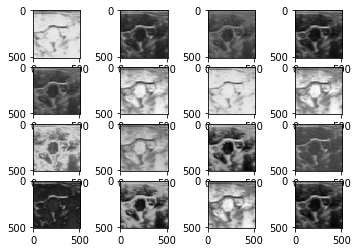

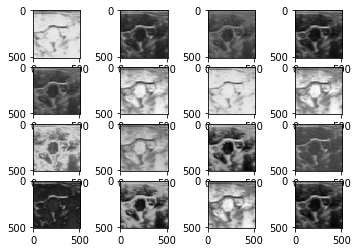

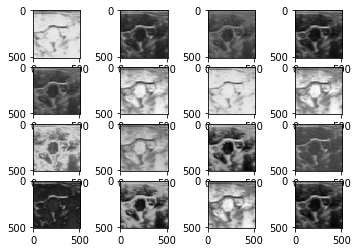

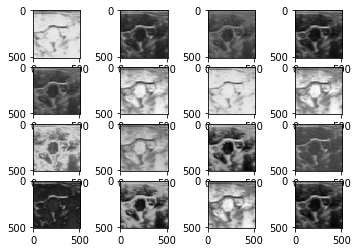

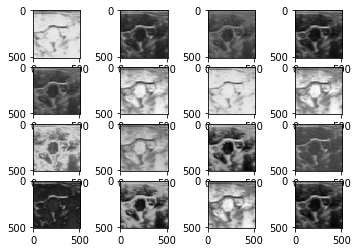

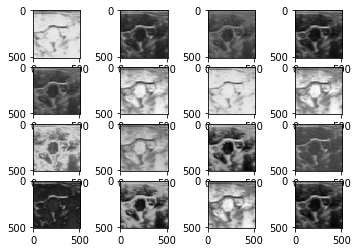

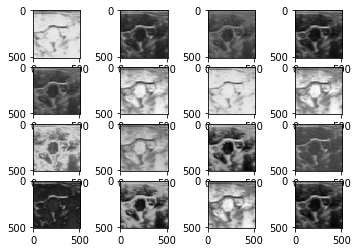

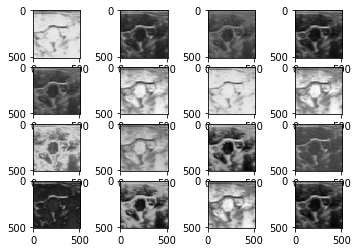

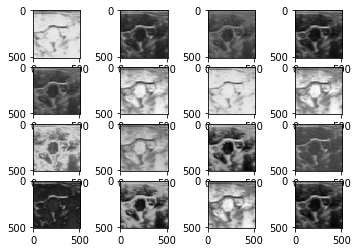

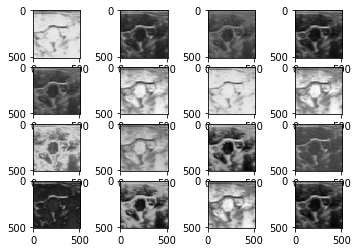

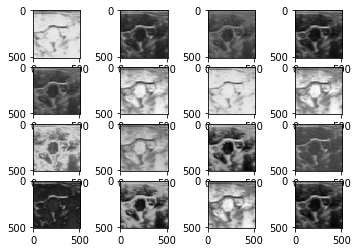

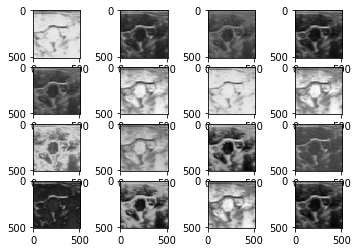

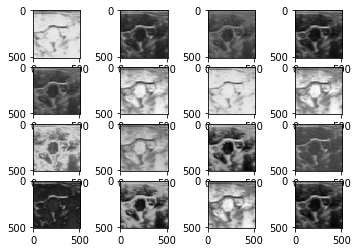

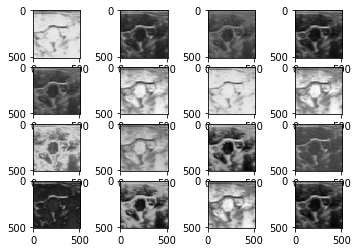

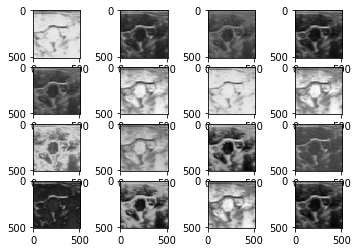

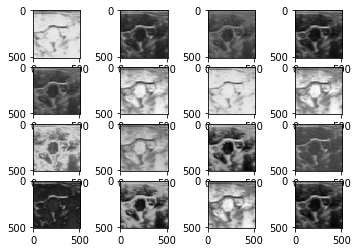

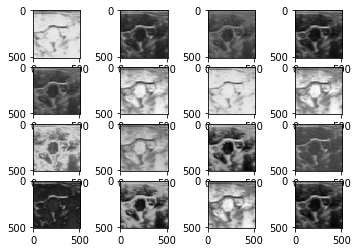

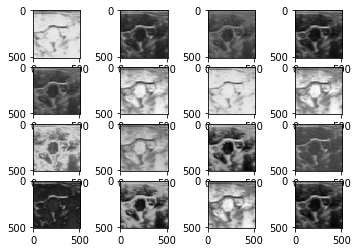

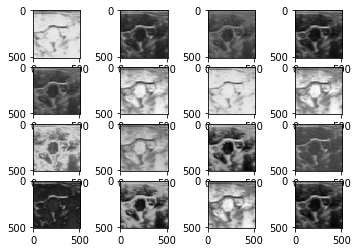

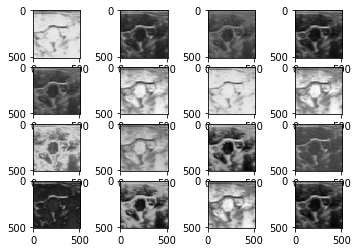

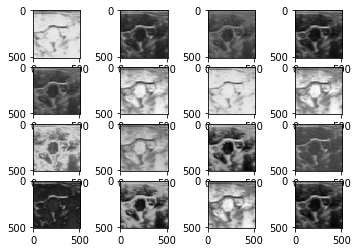

ValueError: num must be 1 <= num <= 25, not 26

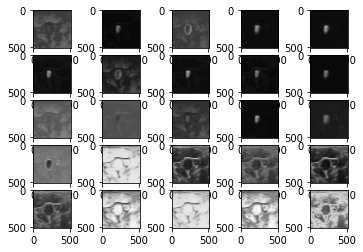

In [26]:
for out in outs:
    image_show(out[0])

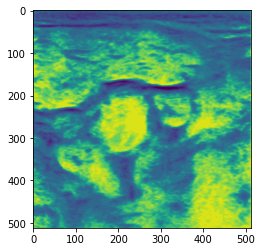

In [ ]:
plt.imshow(out[0][0])

In [90]:
out.shape

(1, 16, 512, 512)

-7 11


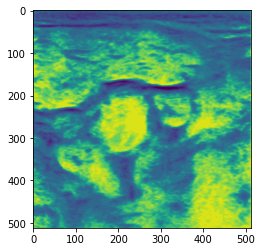

-2 37


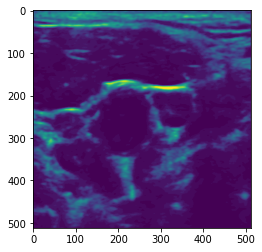

-7 10


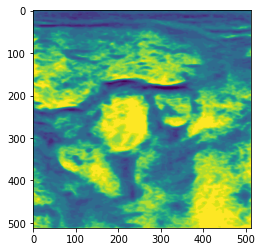

-7 10


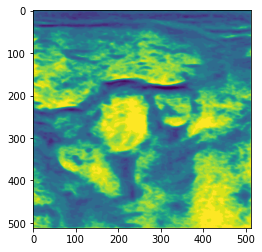

-8 18


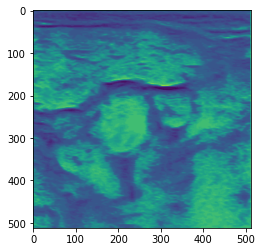

-7 10


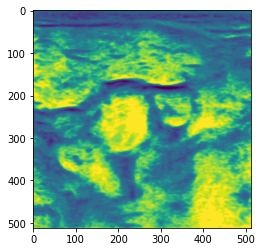

-7 11


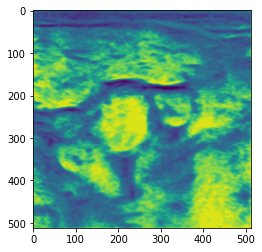

-8 29


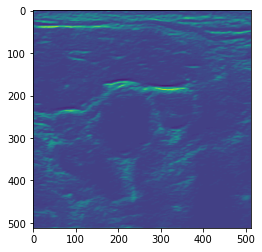

-7 23


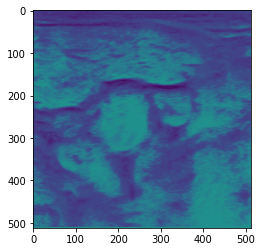

-7 22


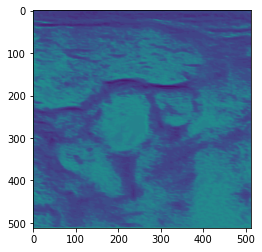

-2 43


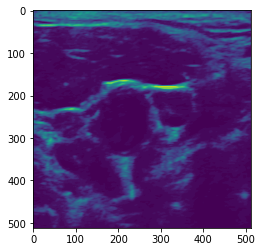

-7 10


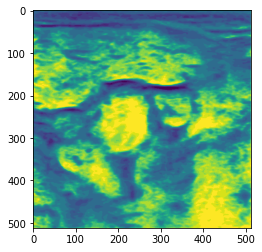

-7 13


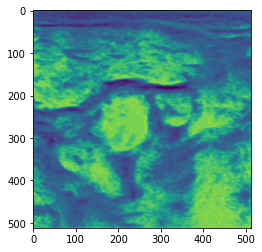

-2 37


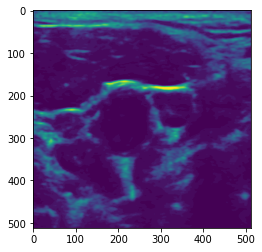

-7 10


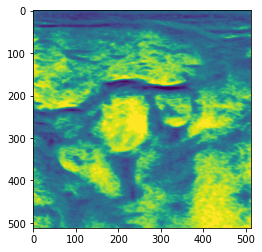

-9 43


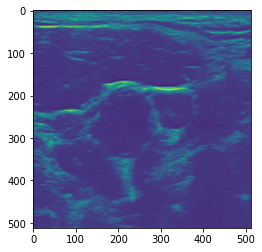

In [89]:
for i in range(16):
    plt.imshow(out[0][i])
    print(np.min(out[0][i].flatten()), np.max(out[0][i].flatten()))
    plt.show()

In [ ]:
plt.subplot(4,4,1)
plt.plot(t1, f(t1))

plt.subplot(222)
plt.plot(t2, g(t2))

plt.subplot(223)
plt.plot(t1, f(t1), 'r-')

plt.subplot(224)
plt.plot(t2, g(t2), 'r-')

plt.show()